In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import requests
import tarfile
import shutil
from tqdm import tqdm
import torch.serialization

# ==================== Configuration ====================

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

batch_size = 64        
num_epochs = 100            
embed_dim = 512          
num_prototypes = 120       
image_size = 224         
num_samples = 1000        
num_workers = 2 if device.type != "mps" else 0 

Using Apple Silicon (MPS)


In [26]:

# ==================== Download Stanford Dogs Dataset ====================
def download_stanford_dogs():
    """
    download Stanford Dogs Dataset
    """
    base_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/"
    dataset_path = "./data/stanford_dogs"
    
    # create directory if it does not exist
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    
    # download annottion
    annotations_url = base_url + "annotation.tar"
    annotations_path = os.path.join(dataset_path, "annotation.tar")
    
    if not os.path.exists(annotations_path):
        print("download annotations...")
        response = requests.get(annotations_url, stream=True)
        with open(annotations_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        with tarfile.open(annotations_path) as tar:
            tar.extractall(path=dataset_path)
    
    # Download Images
    images_url = base_url + "images.tar"
    images_path = os.path.join(dataset_path, "images.tar")
    
    if not os.path.exists(images_path):
        print("Download Images...")
        response = requests.get(images_url, stream=True)
        with open(images_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        with tarfile.open(images_path) as tar:
            tar.extractall(path=dataset_path)
    
    return dataset_path


In [27]:

# ==================== Augmentation ====================
class MultiCropTransform:
    """
    Create two different augmentation versions:
    RandomResizedCrop + Random horizontal flip + ColorJitter + ToTensor + Normalize
    """
    def __init__(self, crop_size):
        self.transform = transforms.Compose([
            transforms.Resize((crop_size, crop_size)),
            transforms.RandomResizedCrop(crop_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        # return list of two images
        im1 = self.transform(x)
        im2 = self.transform(x)
        return [im1, im2]


In [28]:

# ==================== Algorithm Sinkhorn-Knopp ====================
def sinkhorn(out, eps=0.1, iters=3):
    """
    Use Sinkhorn-Knopp to logits 
    return balansed distributions assignments.
    """
    # stabilize
    Q = torch.exp(out / eps).t().clamp(min=1e-6)  # K x B (prototypes х batch)
    Q = Q / Q.sum()
    B = Q.shape[1]
    K = Q.shape[0]
    for _ in range(iters):
        # normolize for prototypes
        Q = Q / Q.sum(dim=1, keepdim=True).clamp(min=1e-6)
        Q = Q / K
        # normolize for batches
        Q = Q / Q.sum(dim=0, keepdim=True).clamp(min=1e-6)
        Q = Q / B
    return (Q * B).t()


In [29]:
# ==================== model SwAV ====================
class SwAVModel(nn.Module):
    """
    Содержит:
    - backbone: ResNet50 for Stanford Dogs
    - projector: projection head (MLP)
    - prototypes: Linear layer without bias, weights is centers of clasters
    """
    def __init__(self, embed_dim, num_prototypes):
        super().__init__()
        # ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=True)
        # freeze weights of ResNet50
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # delete last layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        # size of outputs ResNet50
        feat_dim = 2048

        # projector: MLP 
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, embed_dim)
        )
        # prototypes (clasters centers)
        self.prototypes = nn.Linear(embed_dim, num_prototypes, bias=False)

    def forward(self, x):
        # x: [B, C, H, W]
        with torch.no_grad():  # freeze for backbone
            feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)  
        z = self.projector(feats)           
        z = F.normalize(z, dim=1)           
        p = self.prototypes(z)              
        return z, p

In [30]:
# ==================== prepare and cach data ====================
def prepare_dataset(dataset_path, num_samples):
    """
    prepare and cache dataset
    """
    cache_path = os.path.join(dataset_path, 'processed_cache.pth')
    
    if os.path.exists(cache_path):
        print("Downloading cached data...")
        try:
            with torch.serialization.safe_globals({"torchvision.datasets.folder.ImageFolder"}):
                cached_data = torch.load(cache_path, weights_only=False)
            return cached_data['dataset'], cached_data['indices']
        except Exception as e:
            print(f"Cached data is broken: {e}")
            print("Creating new cache...")
            if os.path.exists(cache_path):
                os.remove(cache_path)
    
    print("Prepare data...")
    transform = MultiCropTransform(image_size)
    dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "Images"), transform=transform)
    
    if len(dataset) > num_samples:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = np.arange(len(dataset))
    
    # cache data
    print("cache data...")
    try:
        with torch.serialization.safe_globals({"torchvision.datasets.folder.ImageFolder"}):
            torch.save({
                'dataset': dataset,
                'indices': indices
            }, cache_path)
    except Exception as e:
        print(f"cant save cache: {e}")
        if os.path.exists(cache_path):
            os.remove(cache_path)
    
    return dataset, indices

In [31]:
# ==================== Обучение SwAV ====================
def train_swav(model, loader, optimizer):
    """
    One epoch of SwAV:
    - get two views: v1, v2
    - calculate embeddings and prototypes loggits
    - with sinkhorn get target assignments
    - minimize cross entropy
    """
    model.train()
    total_loss = 0.0
    
    # create progress bar
    pbar = tqdm(loader, desc='Training', leave=False)
    running_loss = 0.0
    
    for i, (images, _) in enumerate(pbar):
        images = [im.to(device) for im in images]
        
        z1, p1 = model(images[0])
        z2, p2 = model(images[1])
        with torch.no_grad():
            q1 = sinkhorn(p1)
            q2 = sinkhorn(p2)
        # SwAV loss: cross entropy
        loss = - (torch.sum(q2 * F.log_softmax(p1, dim=1), dim=1).mean()
                 + torch.sum(q1 * F.log_softmax(p2, dim=1), dim=1).mean()) * 0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update statistics
        total_loss += loss.item()
        running_loss = total_loss / (i + 1)
        
        # update bar
        pbar.set_postfix({'loss': f'{running_loss:.4f}'})
    
    return total_loss / len(loader)

In [32]:

# ==================== Controfactual ====================
def generate_counterfactual(model, image, target_proto, lr=0.05, steps=300, lambda_reg=1.0, lambda_tv=0.1):
    """
    Generate counterfactual: change image so that it belongs to another cluster
    use gradient descent optimization with several regularization
    """
    model.eval()
    # clone image
    img_cf = image.clone().detach().to(device).requires_grad_(True)
    optimizer = optim.Adam([img_cf], lr=lr)
    
    # calculate Total Variation loss
    def tv_loss(img):
        diff_h = torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]).sum()
        diff_w = torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]).sum()
        return (diff_h + diff_w) / (img.shape[2] * img.shape[3])
    
    for i in range(steps):
        _, p = model(img_cf)
        # loggit of prototype
        proto_logit = p[:, target_proto].mean()
        
        # regularization
        reg_loss = F.mse_loss(img_cf, image.to(device))
        
        tv_reg = tv_loss(img_cf)
        
        # L2 regularization
        l2_reg = torch.norm(img_cf - image.to(device))
        
        # maximize proto_logit
        loss = -proto_logit + lambda_reg * reg_loss + lambda_tv * tv_reg + 0.01 * l2_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # constraints pizels values
        img_cf.data.clamp_(0, 1)
        
        # print progress
        if (i+1) % 50 == 0:
            print(f"Step {i+1}/{steps}, Loss: {loss.item():.4f}, Proto logit: {proto_logit.item():.4f}")
    
    return img_cf.detach()


In [33]:

# ==================== denormalize image ====================
def denormalize(tensor):
    """
    denormalize image [0, 1]
    """
    tensor = tensor.to(device)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    return tensor * std + mean


In [34]:

dataset_path = download_stanford_dogs()
print(f"Dataset path: {dataset_path}")




Dataset path: ./data/stanford_dogs


In [35]:

dataset, indices = prepare_dataset(dataset_path, num_samples)
subset_dataset = Subset(dataset, indices)


In [36]:

# settings for dataloader
loader_args = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': num_workers,
    'pin_memory': device.type == "cuda",  # pin_memory only for CUDA
}

if device.type != "mps":
    loader_args['persistent_workers'] = True

loader = DataLoader(subset_dataset, **loader_args)
print(f"Dataset size: {len(subset_dataset)}")


Dataset size: 1000


In [37]:

model = SwAVModel(embed_dim, num_prototypes).to(device)
model

/Users/macbookpro/Documents/vscode_Projects/xai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/macbookpro/Documents/vscode_Projects/xai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SwAVModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [38]:

lr = 0.005 if device.type == "mps" else 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)



In [39]:

print("\nstart training SwAV...")
print(f"Using device:: {device}")

pbar_epochs = tqdm(range(num_epochs), desc='Epochs')

for epoch in pbar_epochs:
    avg_loss = train_swav(model, loader, optimizer)
    pbar_epochs.set_postfix({'avg_loss': f'{avg_loss:.4f}'})
    
    # clear cache for mps
    if device.type == "mps":
        torch.mps.empty_cache()
    



start training SwAV...
Using device:: mps


Epochs: 100%|██████████| 100/100 [32:22<00:00, 19.42s/it, avg_loss=4.7777]


In [40]:

model.eval()

# choose sample
views, _ = dataset[0]
single_img = views[0].unsqueeze(0)
z, p = model(single_img.to(device))
orig_assign = p.argmax(dim=1).item()
print(f"Original claster: {orig_assign}")


Original claster: 4


In [45]:

# generate counterfactual
target = (orig_assign + 1) % num_prototypes
img_cf = generate_counterfactual(model, single_img, target_proto=target, lr=0.1, steps=10000)
print(f"counterfactual move to: {target}")


Step 50/10000, Loss: 4.4118, Proto logit: 0.0189
Step 100/10000, Loss: 4.4113, Proto logit: 0.0195
Step 150/10000, Loss: 4.4112, Proto logit: 0.0196
Step 200/10000, Loss: 4.4072, Proto logit: 0.0235
Step 250/10000, Loss: 4.4096, Proto logit: 0.0212
Step 300/10000, Loss: 4.4124, Proto logit: 0.0184
Step 350/10000, Loss: 4.4121, Proto logit: 0.0187
Step 400/10000, Loss: 4.4130, Proto logit: 0.0178
Step 450/10000, Loss: 4.4128, Proto logit: 0.0180
Step 500/10000, Loss: 4.4095, Proto logit: 0.0213
Step 550/10000, Loss: 4.4126, Proto logit: 0.0182
Step 600/10000, Loss: 4.4131, Proto logit: 0.0178
Step 650/10000, Loss: 4.4116, Proto logit: 0.0192
Step 700/10000, Loss: 4.4078, Proto logit: 0.0230
Step 750/10000, Loss: 4.4155, Proto logit: 0.0153
Step 800/10000, Loss: 4.4087, Proto logit: 0.0221
Step 850/10000, Loss: 4.4163, Proto logit: 0.0146
Step 900/10000, Loss: 4.4122, Proto logit: 0.0186
Step 950/10000, Loss: 4.4105, Proto logit: 0.0203
Step 1000/10000, Loss: 4.4097, Proto logit: 0.0211


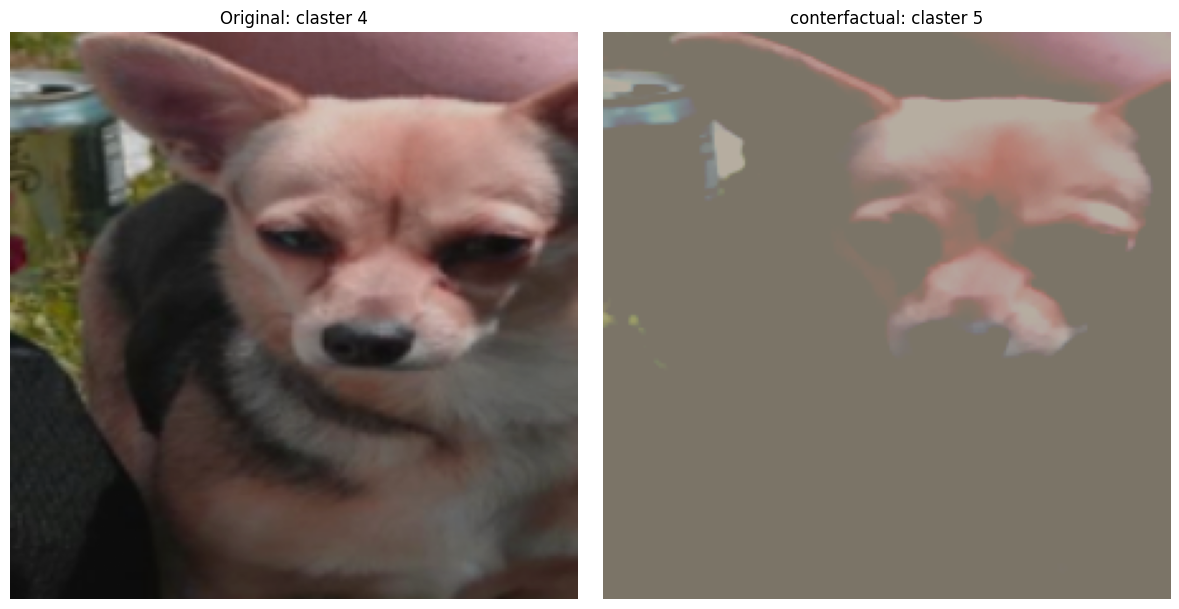

In [46]:

# visualize
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# denormalize
orig_img = denormalize(single_img).cpu()
cf_img = denormalize(img_cf).cpu()

# from [C, H, W] to [H, W, C] for visualize
orig_img = orig_img[0].permute(1, 2, 0)
cf_img = cf_img[0].permute(1, 2, 0)

axs[0].imshow(orig_img)
axs[0].set_title(f'Original: claster {orig_assign}')
axs[0].axis('off')
axs[1].imshow(cf_img)
axs[1].set_title(f'conterfactual: claster {target}')
axs[1].axis('off')
plt.tight_layout()
plt.savefig('counterfactual_dogs.png')
plt.show()



In [43]:
# ==================== Visualise clasters ====================
def visualize_cluster_members(model, dataset, image_idx, num_neighbors=10):
    """
    visualize cluster mambers:
    - show original image
    - find claster
    - show some images in same claster
    """
    model.eval()
    
    # get original image
    views, _ = dataset[image_idx]
    target_img = views[0].unsqueeze(0).to(device)
    
    # find claster
    with torch.no_grad():
        _, p = model(target_img)
        target_cluster = p.argmax(dim=1).item()
    
    all_images = []
    cluster_assignments = []
    
    print("Calculate clasters of all images...")
    with torch.no_grad():
        for idx in range(len(dataset)):
            if idx % 100 == 0:
                print(f"done {idx}/{len(dataset)} images")
            views, _ = dataset[idx]
            img = views[0].unsqueeze(0).to(device)
            _, p = model(img)
            cluster = p.argmax(dim=1).item()
            
            if cluster == target_cluster:
                all_images.append(views[0])
                cluster_assignments.append(idx)
                if len(cluster_assignments) >= num_neighbors:
                    break
    
    # choose random images in same claster
    if len(cluster_assignments) > num_neighbors:
        neighbor_indices = np.random.choice(len(cluster_assignments), num_neighbors, replace=False)
        neighbor_images = [all_images[i] for i in neighbor_indices]
    else:
        neighbor_images = all_images
        
    # Visualize
    num_images = min(len(neighbor_images) + 1, num_neighbors + 1)
    fig = plt.figure(figsize=(20, 4))
    
    # show Original image
    plt.subplot(1, num_images, 1)
    orig_img = denormalize(target_img).cpu()[0].permute(1, 2, 0)
    plt.imshow(orig_img)
    plt.title(f'Target Image\nCluster {target_cluster}')
    plt.axis('off')
    
    # Show neighboors
    for i, img in enumerate(neighbor_images[:num_neighbors]):
        plt.subplot(1, num_images, i + 2)
        img = denormalize(img.unsqueeze(0).to(device)).cpu()[0].permute(1, 2, 0)
        plt.imshow(img)
        plt.title(f'Neighbor {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('cluster_members.png')
    plt.show()
    
    print(f"Find {len(cluster_assignments)} images in claster {target_cluster}")
    return cluster_assignments


Check clasters quality...
Calculate clasters of all images...
done 0/20580 images


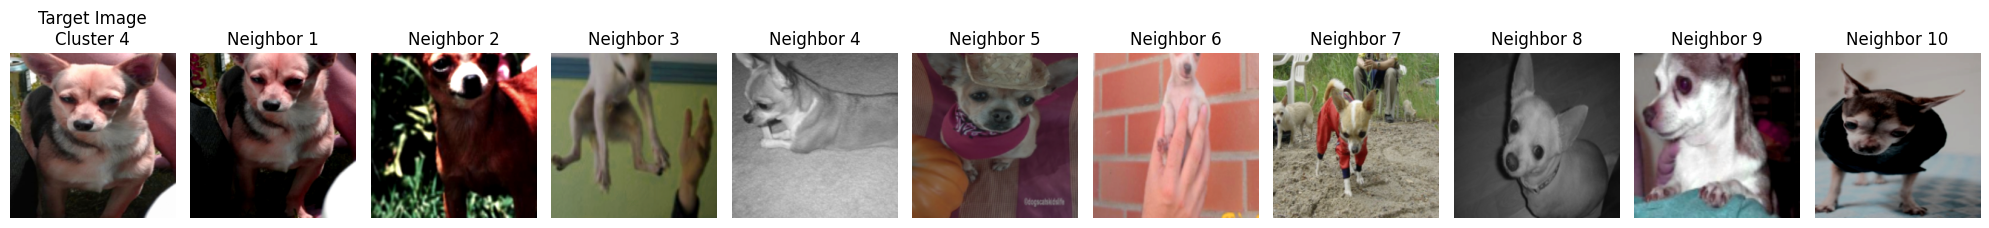

Find 10 images in claster 4


In [44]:

print("\nCheck clasters quality...")
cluster_members = visualize_cluster_members(model, dataset, 0)
